In [19]:
!pip install ultralytics mediapipe opencv-python ffmpeg-python tqdm


In [2]:
pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.3 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from tqdm import tqdm
from google.colab import files
from IPython.display import Image, display, Video

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("Uploaded video:", video_path)


Saving VIRAT KOHLI SIDE BATTING VIEW!!! PURE ELEGANCE 😍 #Shorts.mp4 to VIRAT KOHLI SIDE BATTING VIEW!!! PURE ELEGANCE 😍 #Shorts.mp4
Uploaded video: VIRAT KOHLI SIDE BATTING VIEW!!! PURE ELEGANCE 😍 #Shorts.mp4


In [5]:
tracker = DeepSort(max_age=100, n_init=2)


0: 640x448 1 person, 1 frisbee, 55.1ms
Speed: 3.6ms preprocess, 55.1ms inference, 105.9ms postprocess per image at shape (1, 3, 640, 448)
Detected athletes:
ID 0: Box (97, 104, 215, 368)
ID 1: Box (213, 78, 247, 85)


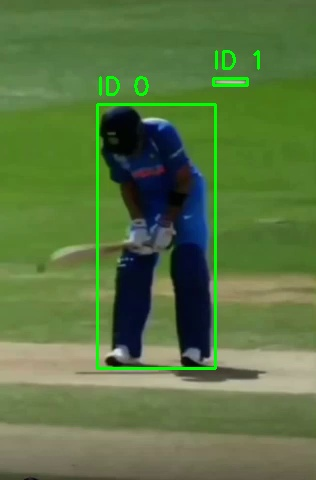

In [6]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise Exception("Cannot read video")

results = yolo_model(frame)
boxes = results[0].boxes.xyxy.cpu().numpy()  # bounding boxes
masks = results[0].masks.data.cpu().numpy()  # segmentation masks

# Show first frame with IDs
frame_copy = frame.copy()
print("Detected athletes:")
for i, (x1, y1, x2, y2) in enumerate(boxes.astype(int)):
    cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(frame_copy, f"ID {i}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    print(f"ID {i}: Box ({x1}, {y1}, {x2}, {y2})")

cv2.imwrite("detections_preview.jpg", frame_copy)
from IPython.display import Image, display
display(Image("detections_preview.jpg"))
cap.release()


In [7]:
user_input = input("Enter the ID number of your athlete: ").strip()
player_idx = int(user_input)

selected_box = boxes[player_idx].astype(int)
selected_mask_init = masks[player_idx]

print(f"✅ Selected athlete ID {player_idx}")


Enter the ID number of your athlete: 0
✅ Selected athlete ID 0


In [8]:
import cv2
import numpy as np
from tqdm import tqdm
from collections import deque


In [16]:
from ultralytics import YOLO
import cv2
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Load YOLO models on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

yolo_model = YOLO("yolov8s-seg.pt").to(device)
pose_model = YOLO("yolov8s-pose.pt").to(device)

def moving_average(x, w=5):
    """Simple moving average for smoothing."""
    return np.convolve(x, np.ones(w)/w, mode='same')

def isolate_selected_person_stable_masked_bg_with_pose(
    video_path,
    selected_box,
    selected_mask_init,
    output_path="processed_athlete_pose_masked.mp4",
    edge_margin=40,
    expand_pixels=25,
    dilate_kernel_size=15,
    temporal_smooth=0.6,
    iou_match_thresh=0.3,
    missing_patience=10,
    fade_decay=0.96,
    pose_conf_thresh=0.25,
    draw_skeleton=True,
    infer_size=640,
    frame_skip=1
):
    """
    CUDA-accelerated YOLOv8 segmentation + pose estimation.
    Produces video, CSV metrics, and cricket-specific smoothed plots.
    """

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    previous_mask = cv2.resize(selected_mask_init, (width, height)).astype(np.float32)

    skeleton_pairs = [
        (5, 7), (7, 9), (6, 8), (8, 10), (5, 6),
        (5, 11), (6, 12), (11, 13), (13, 15),
        (12, 14), (14, 16)
    ]

    all_keypoints = []

    def iou_box(a, b):
        ax1, ay1, ax2, ay2 = a
        bx1, by1, bx2, by2 = b
        inter_w = max(0, min(ax2, bx2) - max(ax1, bx1))
        inter_h = max(0, min(ay2, by2) - max(ay1, by1))
        inter = inter_w * inter_h
        area_a = max(1.0, (ax2 - ax1) * (ay2 - ay1))
        area_b = max(1.0, (bx2 - bx1) * (by2 - by1))
        return inter / (area_a + area_b - inter + 1e-9)

    print(f"\n🎥 Processing {total_frames} frames on {device.upper()} ...")

    for frame_idx in tqdm(range(total_frames), desc="Processing video"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            continue

        # --- YOLO segmentation ---
        results = yolo_model(frame, verbose=False, imgsz=infer_size, device=device)
        masks_curr, boxes_curr = [], []

        if results and hasattr(results[0], "masks") and results[0].masks is not None:
            try:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                masks_data = results[0].masks.data.cpu().numpy()
                for box, mask_data in zip(boxes, masks_data):
                    x1, y1, x2, y2 = box[:4]
                    x1 = max(0, x1 - expand_pixels)
                    y1 = max(0, y1 - expand_pixels)
                    x2 = min(width, x2 + expand_pixels)
                    y2 = min(height, y2 + expand_pixels)

                    mask_resized = cv2.resize(mask_data, (width, height))
                    masks_curr.append(np.clip(mask_resized, 0, 1).astype(np.float32))
                    boxes_curr.append([x1, y1, x2, y2])
            except Exception:
                masks_curr, boxes_curr = [], []

        # --- Select athlete mask ---
        athlete_mask = previous_mask.copy()
        if len(boxes_curr) > 0:
            best_iou, best_mask = 0, None
            for det_box, mask in zip(boxes_curr, masks_curr):
                cur_iou = iou_box(det_box, selected_box)
                if cur_iou > best_iou:
                    best_iou, best_mask = cur_iou, mask
            if best_mask is not None and best_iou > iou_match_thresh:
                athlete_mask = best_mask

        athlete_mask = temporal_smooth * previous_mask + (1 - temporal_smooth) * athlete_mask
        previous_mask = athlete_mask.copy()

        # --- Morphological refinement ---
        athlete_mask_bin = (athlete_mask > 0.5).astype(np.uint8)
        kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
        athlete_mask_bin = cv2.dilate(athlete_mask_bin, kernel, iterations=1)
        athlete_mask_bin = cv2.morphologyEx(athlete_mask_bin, cv2.MORPH_CLOSE, kernel)
        athlete_mask_bin = (cv2.GaussianBlur(athlete_mask_bin.astype(np.float32), (5, 5), 1) > 0.4).astype(np.uint8)

        masked_frame = frame * athlete_mask_bin[:, :, None]

        # --- YOLO Pose ---
        pose_results = pose_model(masked_frame, verbose=False, imgsz=infer_size, device=device)
        frame_kpts = None

        for r in pose_results:
            if not hasattr(r, "keypoints") or r.keypoints is None:
                continue
            if getattr(r.keypoints, "data", None) is None:
                continue

            keypoints = r.keypoints.data.cpu().numpy()
            if keypoints.size == 0:
                continue

            person_kpts = keypoints[0][:, :2]  # (17,2)
            frame_kpts = person_kpts

            # Draw keypoints
            for i, (x, y) in enumerate(person_kpts):
                cv2.circle(masked_frame, (int(x), int(y)), 3, (0, 255, 0), -1)
            if draw_skeleton:
                for a, b in skeleton_pairs:
                    cv2.line(masked_frame,
                             (int(person_kpts[a][0]), int(person_kpts[a][1])),
                             (int(person_kpts[b][0]), int(person_kpts[b][1])),
                             (255, 255, 0), 2)

        all_keypoints.append(frame_kpts)
        out.write(np.uint8(masked_frame))

    cap.release()
    out.release()
    print(f"\n✅ Processed video saved to {output_path}")

    # --- Metrics Analysis (normalized) ---
    all_keypoints_np = np.array([k if k is not None else np.full((17, 2), np.nan) for k in all_keypoints])

    # Normalize relative to torso center (midpoint of left/right shoulder)
    torso_centers = (all_keypoints_np[:, 5, :] + all_keypoints_np[:, 2, :]) / 2  # (frames,2)
    norm_keypoints = all_keypoints_np - torso_centers[:, None, :]

    # Backlift height: right wrist (4) vertical relative to torso
    backlift_height = norm_keypoints[:, 4, 1]  # Y relative to torso
    backlift_height = moving_average(backlift_height, w=5)

    # Head stability: nose (0) X/Y relative to torso
    head_x = moving_average(norm_keypoints[:, 0, 0], w=5)
    head_y = moving_average(norm_keypoints[:, 0, 1], w=5)

    # Shoulder rotation: angle between left (5) and right (2) shoulders
    def angle(p1, p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        return np.degrees(np.arctan2(dy, dx))

    shoulder_angles = np.array([angle(all_keypoints_np[i,5], all_keypoints_np[i,2])
                                if not np.any(np.isnan(all_keypoints_np[i,[5,2]])) else np.nan
                                for i in range(len(all_keypoints_np))])
    shoulder_angles = moving_average(shoulder_angles, w=5)

    # Front foot placement: left foot (15) X relative to torso
    foot_x = moving_average(norm_keypoints[:, 15, 0], w=5)

    # --- Plot metrics ---
    plt.figure(figsize=(12,4)); plt.plot(backlift_height, label="Backlift Height"); plt.title("Batsman Backlift"); plt.xlabel("Frame"); plt.ylabel("Pixels"); plt.legend(); plt.show()
    plt.figure(figsize=(12,4)); plt.plot(head_x, label="Head X"); plt.plot(head_y, label="Head Y"); plt.title("Head Stability"); plt.xlabel("Frame"); plt.ylabel("Pixels"); plt.legend(); plt.show()
    plt.figure(figsize=(12,4)); plt.plot(shoulder_angles, label="Shoulder Rotation"); plt.title("Shoulder Rotation"); plt.xlabel("Frame"); plt.ylabel("Angle (deg)"); plt.legend(); plt.show()
    plt.figure(figsize=(12,4)); plt.plot(foot_x, label="Front Foot X"); plt.title("Front Foot Placement"); plt.xlabel("Frame"); plt.ylabel("Pixels"); plt.legend(); plt.show()

    # --- Save CSV ---
    df = pd.DataFrame({
        "frame": range(len(all_keypoints_np)),
        "backlift_height": backlift_height,
        "head_x": head_x,
        "head_y": head_y,
        "shoulder_angle": shoulder_angles,
        "foot_x": foot_x
    })
    df.to_csv("batsman_analysis.csv", index=False)
    print("\n✅ CSV metrics saved.")

    return output_path, df


🚀 Using device: cuda



🎥 Processing 613 frames on CUDA ...


Processing video: 100%|██████████| 613/613 [00:17<00:00, 35.14it/s]



✅ Processed video saved to processed_athlete_pose_masked.mp4


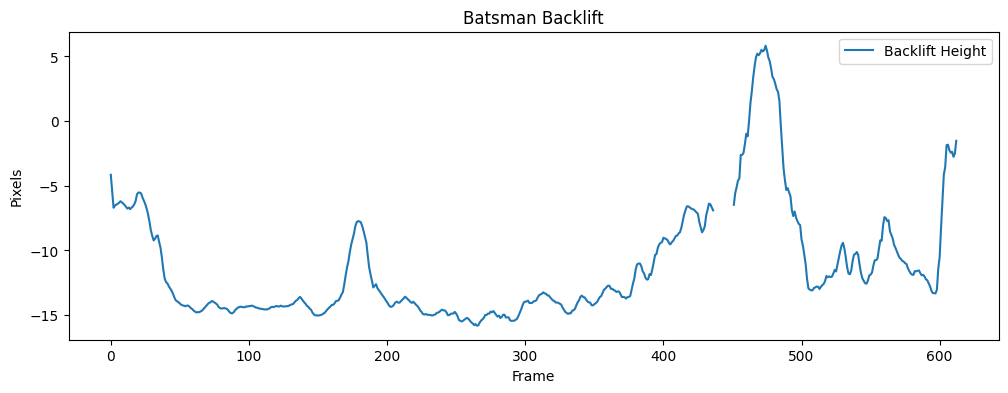

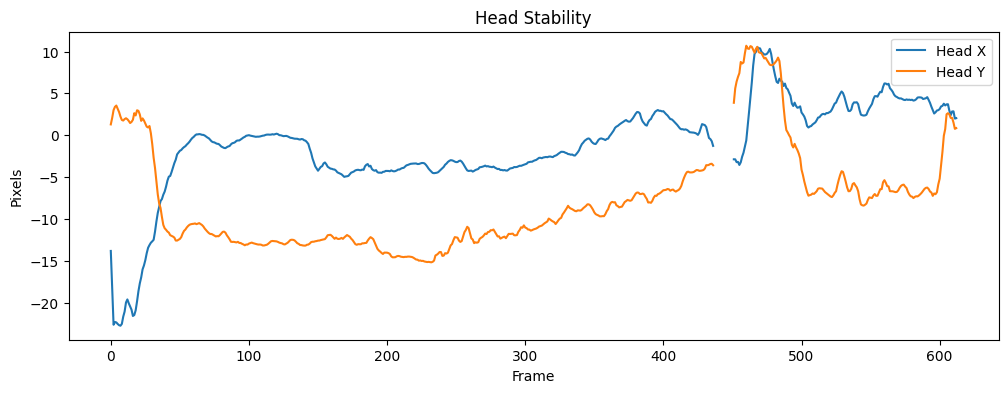

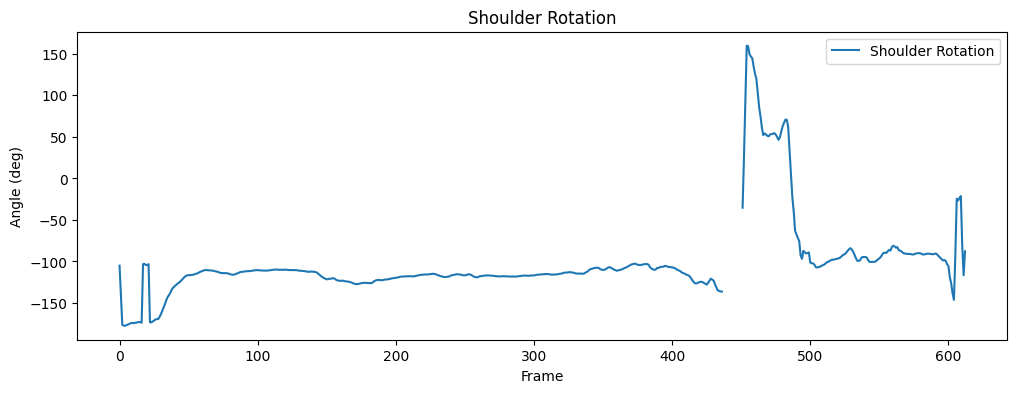

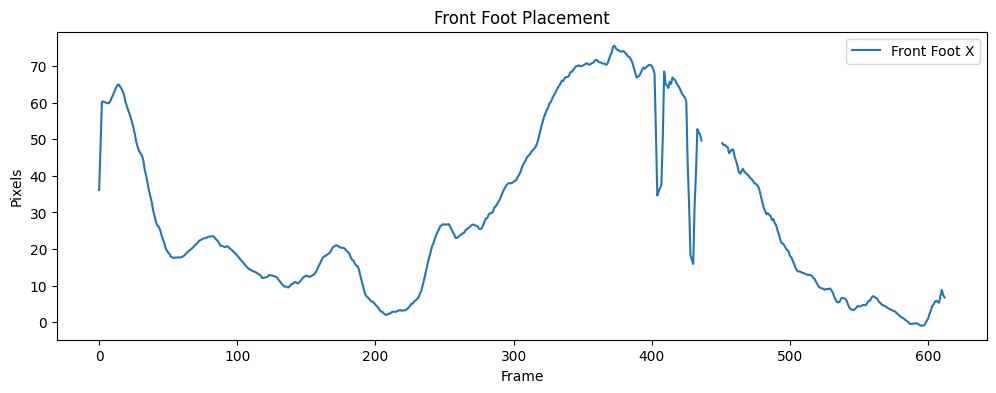


✅ CSV metrics saved.


In [18]:
output_path, csv = isolate_selected_person_stable_masked_bg_with_pose(
    video_path,
    selected_box,
    selected_mask_init
)

In [15]:
from IPython.display import Video, display
display(Video(output_path, embed=True))
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>